In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.5, 0.25, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 30/30 [02:13<00:00,  4.46s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 529/529 [00:22<00:00, 23.03it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.33014044401301534,
 'epoch': 30,
 'train_loss': 0.038478307,
 'val_loss': 0.044518963,
 'train_acc': 0.47600001096725464,
 'val_acc': 0.47200000286102295,
 'val_rmse_perc': 0.20957714,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.47_4_[10_15_20]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_dist_10_False_0_30',
 'train_rmse': 0.8555699854482975,
 'val_rmse': 0.8988882021697693,
 'test_rmse': 0.8310635755865291,
 'train_mae': 0.5933333333333334,
 'val_mae': 0.6213333333333333,
 'test_mae': 0.568,
 'train_mcc': 0.31464225338595087,
 'test_mcc': 0.3420813505739071,
 'test_acc

In [11]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.29388575275715434,
 'epoch': 60,
 'train_loss': 0.03675827,
 'val_loss': 0.04048043,
 'train_acc': 0.4880000054836273,
 'val_acc': 0.4533333480358124,
 'val_rmse_perc': 0.2000477,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.45_4_[10_15_20]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_dist_10_False_0_60',
 'train_rmse': 0.8334666560017063,
 'val_rmse': 0.8406346808612327,
 'test_rmse': 0.8310635755865291,
 'train_mae': 0.572,
 'val_mae': 0.6,
 'test_mae': 0.5786666666666667,
 'train_mcc': 0.3311767373729216,
 'test_mcc': 0.3149553579497303,
 'test_acc': 0.4773333370685577

In [12]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.31655505588824134,
 'epoch': 100,
 'train_loss': 0.03675438,
 'val_loss': 0.040476333,
 'train_acc': 0.4893333315849304,
 'val_acc': 0.46933332085609436,
 'val_rmse_perc': 0.20005569,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.47_4_[10_15_20]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_dist_10_False_0_100',
 'train_rmse': 0.8326663997864531,
 'val_rmse': 0.8358628276617323,
 'test_rmse': 0.827848617401354,
 'train_mae': 0.5706666666666667,
 'val_mae': 0.5866666666666667,
 'test_mae': 0.5786666666666667,
 'train_mcc': 0.33291310383659606,
 'test_mcc': 0.3106542735090292

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 529/529 [00:00<00:00, 23061.68it/s]


In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

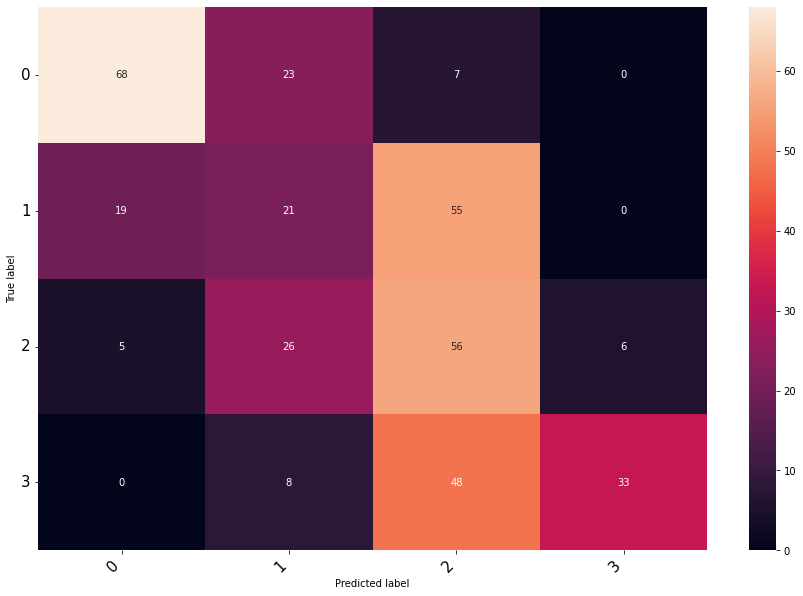

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.6939, 0.2211, 0.6022, 0.3708])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.18312046, 0.19677673, 0.16280712, 0.20599832]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.15329583, 0.17520426, 0.12945992, 0.17897111]

### GCN

In [20]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [09:03<00:00,  7.55s/it]


#### Results

In [22]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1155/1155 [01:22<00:00, 13.98it/s]


In [23]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3227255089888477,
 'epoch': 30,
 'train_loss': 0.05577005,
 'val_loss': 0.047384333,
 'train_acc': 0.4333333373069763,
 'val_acc': 0.42133334279060364,
 'val_rmse_perc': 0.21858281,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.42_4_[5_10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_True_mse_dist_10_True_0_30',
 'train_rmse': 0.9179687721631203,
 'val_rmse': 0.8854377448471462,
 'test_rmse': 0.920869154657707,
 'train_mae': 0.6506666666666666,
 'val_mae': 0.6453333333333333,
 'test_mae': 0.6346666666666667,
 'train_mcc': 0.3133931835812477,
 'te

In [24]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.32197881111652843,
 'epoch': 90,
 'train_loss': 0.044584177,
 'val_loss': 0.046585403,
 'train_acc': 0.4266666769981384,
 'val_acc': 0.41066667437553406,
 'val_rmse_perc': 0.2152487,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.41_4_[15_15_15]_4_ReLU()_none_bn_0.2_0.1_adamw_max_val_mcc_True_mse_dist_10_True_0_90',
 'train_rmse': 0.8771164878927618,
 'val_rmse': 0.8702490065109717,
 'test_rmse': 0.9280804562823922,
 'train_mae': 0.6386666666666667,
 'val_mae': 0.6453333333333333,
 'test_mae': 0.6853333333333333,
 'train_mcc': 0.31772528022497004,
 'test_m

In [25]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.29276411322043655,
 'epoch': 50,
 'train_loss': 0.053116724,
 'val_loss': 0.046962306,
 'train_acc': 0.4386666715145111,
 'val_acc': 0.4000000059604645,
 'val_rmse_perc': 0.21632743,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.40_4_[10_15_20]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_True_mse_dist_10_True_0.2_50',
 'train_rmse': 0.8748333174572933,
 'val_rmse': 0.9018499505645788,
 'test_rmse': 0.8988882021697693,
 'train_mae': 0.6293333333333333,
 'val_mae': 0.6693333333333333,
 'test_mae': 0.6586666666666666,
 'train_mcc': 0.3258974434770981,
 'tes

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1155/1155 [00:00<00:00, 21850.95it/s]


### GraphSAGE

In [27]:
save_model = f'{save_path}_sage_dist'
log_dir = f'{log_path}_sage_dist'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [28]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 144/144 [4:19:44<00:00, 108.23s/it]  


#### Results

In [29]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 3213/3213 [23:56<00:00,  2.24it/s]


True

In [30]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8237219302916778,
 'epoch': 60,
 'train_loss': 0.0037847343,
 'val_loss': 0.0063893446,
 'train_acc': 0.9546666741371155,
 'val_acc': 0.8666666746139526,
 'val_rmse_perc': 0.059879407,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.87_4_[20_20_20]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_dist_10_True_0_60',
 'train_rmse': 0.21291625896895083,
 'val_rmse': 0.3651483716701107,
 'test_rmse': 0.38987177379235854,
 'train_mae': 0.04533333333333334,
 'val_mae': 0.13333333333333333,
 'test_mae': 0.141333333333333

In [31]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8436347616207512,
 'epoch': 70,
 'train_loss': 0.0031792342,
 'val_loss': 0.0057368344,
 'train_acc': 0.9613333344459534,
 'val_acc': 0.8826666474342346,
 'val_rmse_perc': 0.057393417,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.88_4_[20_20_20]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_dist_10_True_0_70',
 'train_rmse': 0.19663841605003501,
 'val_rmse': 0.34253953543107013,
 'test_rmse': 0.4226897995772629,
 'train_mae': 0.03866666666666667,
 'val_mae': 0.11733333333333333,
 'test_mae': 0.168,
 'train_mc

In [32]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8436347616207512,
 'epoch': 70,
 'train_loss': 0.0031792342,
 'val_loss': 0.0057368344,
 'train_acc': 0.9613333344459534,
 'val_acc': 0.8826666474342346,
 'val_rmse_perc': 0.057393417,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.88_4_[20_20_20]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_dist_10_True_0_70',
 'train_rmse': 0.19663841605003501,
 'val_rmse': 0.34253953543107013,
 'test_rmse': 0.4226897995772629,
 'train_mae': 0.03866666666666667,
 'val_mae': 0.11733333333333333,
 'test_mae': 0.168,
 'train_mc

In [33]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3213/3213 [00:00<00:00, 24041.98it/s]


#### cm

In [34]:
cm = all[sort_idx[0]]['test_cm'][0]

In [35]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

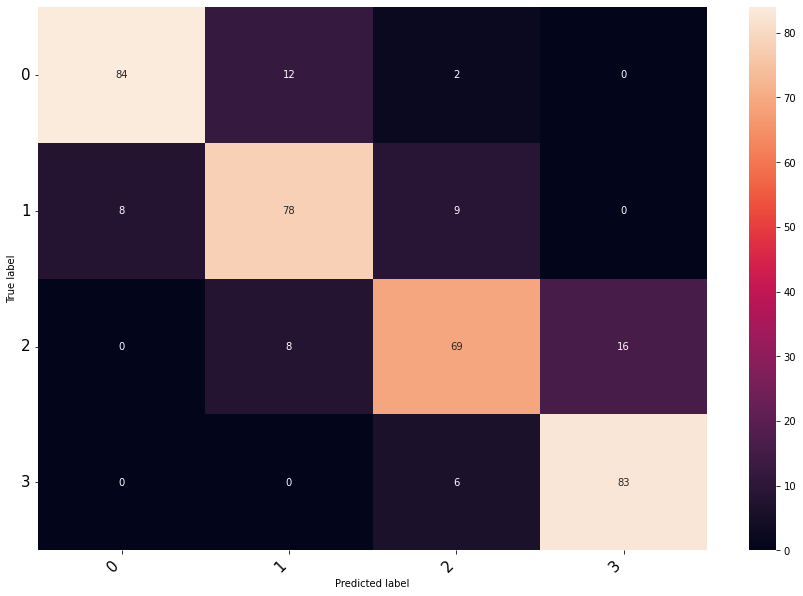

In [36]:
cm.visualize()

In [37]:
cm.class_accuracy

tensor([0.8571, 0.8211, 0.7419, 0.9326])

In [38]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.08588196, 0.08020757, 0.07294161, 0.062421564]

In [39]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.05510087, 0.054581784, 0.05386757, 0.049193453]

#### GraphSAGE Base_n

In [40]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [41]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='base_n',
        )

100%|██████████| 144/144 [4:13:24<00:00, 105.59s/it]  


##### Results

In [42]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='base_n',
)

toast.show_toast("Done")

100%|██████████| 2403/2403 [17:07<00:00,  2.34it/s]


True

In [43]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7209613440888836,
 'epoch': 62,
 'train_loss': 0.0034349638,
 'val_loss': 0.018364595,
 'train_acc': 0.8293333053588867,
 'val_acc': 0.7839999794960022,
 'val_rmse_perc': 0.09960751,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.78_4_[20_25_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.4131182235954578,
 'val_rmse': 0.4732863826479693,
 'test_rmse': 0.5240865068542279,
 'train_mae': 0.17066666666666666,
 'val_mae': 0.21866666666666668,
 'test_mae': 0.264,
 'train_mcc':

In [44]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7209613440888836,
 'epoch': 62,
 'train_loss': 0.0034349638,
 'val_loss': 0.018364595,
 'train_acc': 0.8293333053588867,
 'val_acc': 0.7839999794960022,
 'val_rmse_perc': 0.09960751,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.78_4_[20_25_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.4131182235954578,
 'val_rmse': 0.4732863826479693,
 'test_rmse': 0.5240865068542279,
 'train_mae': 0.17066666666666666,
 'val_mae': 0.21866666666666668,
 'test_mae': 0.264,
 'train_mcc':

In [45]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7209613440888836,
 'epoch': 62,
 'train_loss': 0.0034349638,
 'val_loss': 0.018364595,
 'train_acc': 0.8293333053588867,
 'val_acc': 0.7839999794960022,
 'val_rmse_perc': 0.09960751,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.78_4_[20_25_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.4131182235954578,
 'val_rmse': 0.4732863826479693,
 'test_rmse': 0.5240865068542279,
 'train_mae': 0.17066666666666666,
 'val_mae': 0.21866666666666668,
 'test_mae': 0.264,
 'train_mcc':

In [46]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2403/2403 [00:00<00:00, 23167.68it/s]


##### cm

In [47]:
cm = all[sort_idx[0]]['test_cm'][0]

In [48]:
(cm.labels==0).sum()

tensor(98)

In [49]:
cm.pseudo_perc.max()

tensor(0.9977)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

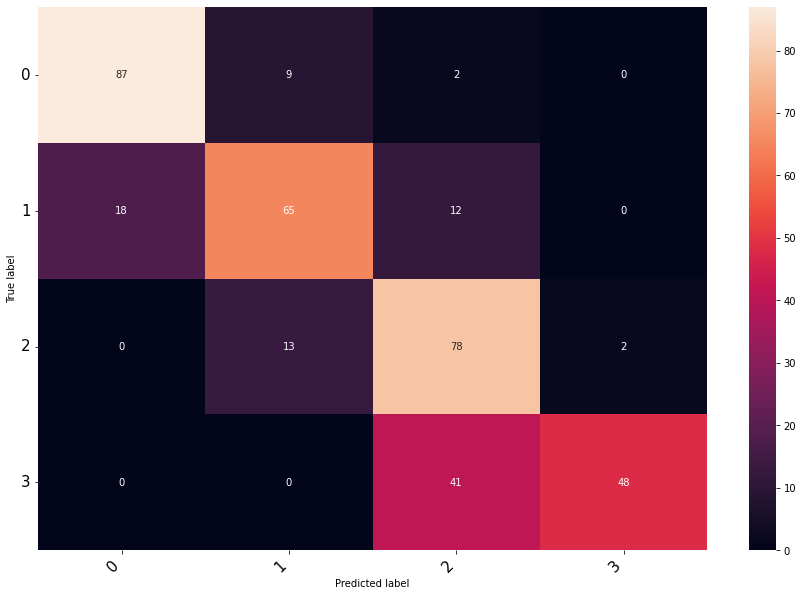

In [50]:
cm.visualize()

In [51]:
cm.class_accuracy

tensor([0.8878, 0.6842, 0.8387, 0.5393])

In [52]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.09323333, 0.10123821, 0.0812563, 0.13678426]

In [53]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.0665246, 0.07744544, 0.06234252, 0.123248756]

#### GraphSAGE Scale

In [54]:
save_model = f'{save_path}_sage_scale'
log_dir = f'{log_path}_sage_scale'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [55]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='scale',
        )

100%|██████████| 144/144 [3:56:53<00:00, 98.70s/it]  


##### Results

In [56]:
res_edges_sage_dist = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='scale',
)

toast.show_toast("Done")

100%|██████████| 3149/3149 [14:24<00:00,  3.64it/s]


True

In [57]:
res_edges = res_edges_sage_dist
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.8106947989615165,
 'epoch': 86,
 'train_loss': 0.020301845,
 'val_loss': 0.012750862,
 'train_acc': 0.9106666445732117,
 'val_acc': 0.8560000061988831,
 'val_rmse_perc': 0.094197154,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.86_4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0.2',
 'train_rmse': 0.2988868236194653,
 'val_rmse': 0.3794733192202055,
 'test_rmse': 0.511207720338155,
 'train_mae': 0.08933333333333333,
 'val_mae': 0.144,
 'test_mae': 0.208,
 'train_mcc': 0.884442560

In [58]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.7710140927739214,
 'epoch': 70,
 'train_loss': 0.019912986,
 'val_loss': 0.016366918,
 'train_acc': 0.8999999761581421,
 'val_acc': 0.8266666531562805,
 'val_rmse_perc': 0.09100016,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.83_4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0.2_70',
 'train_rmse': 0.31622776601683794,
 'val_rmse': 0.43512450325548585,
 'test_rmse': 0.5416025603090641,
 'train_mae': 0.1,
 'val_mae': 0.17866666666666667,
 'test_mae': 0.25066666666666665,
 'train_

In [59]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.7784125046159223,
 'epoch': 84,
 'train_loss': 0.022825103,
 'val_loss': 0.014360641,
 'train_acc': 0.9079999923706055,
 'val_acc': 0.8320000171661377,
 'val_rmse_perc': 0.09213271,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.83_4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0.2',
 'train_rmse': 0.30331501776206204,
 'val_rmse': 0.41952353926806063,
 'test_rmse': 0.511207720338155,
 'train_mae': 0.092,
 'val_mae': 0.17066666666666666,
 'test_mae': 0.21866666666666668,
 'train_mc

In [60]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3149/3149 [00:00<00:00, 22607.42it/s]


##### cm

In [61]:
cm = all[sort_idx[0]]['test_cm'][0]

In [62]:
(cm.labels==0).sum()

tensor(98)

In [63]:
cm.pseudo_perc.max()

tensor(0.9998)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

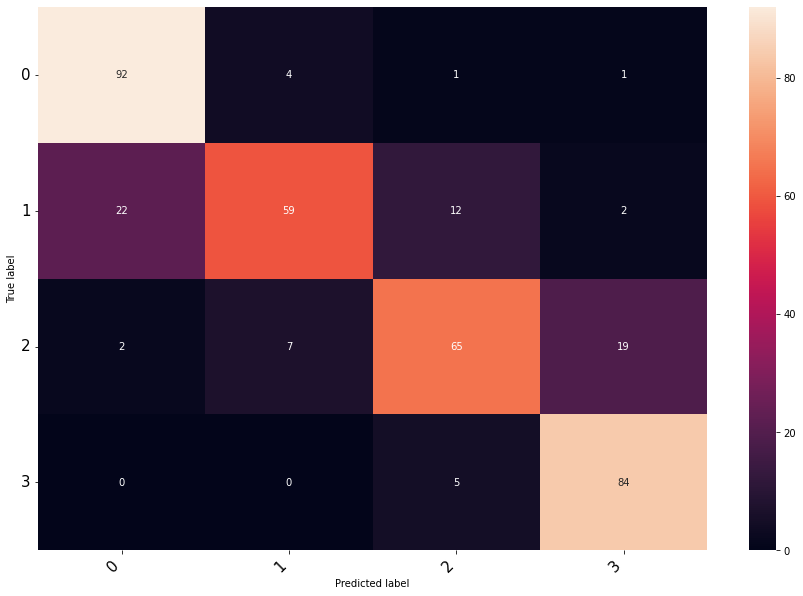

In [64]:
cm.visualize()

In [65]:
cm.class_accuracy

tensor([0.9388, 0.6211, 0.6989, 0.9438])

In [66]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.12202085, 0.13300703, 0.09736711, 0.067289785]

In [67]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.09089061, 0.09813127, 0.06871912, 0.051760916]

### GAT

In [68]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [69]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 288/288 [29:01<00:00,  6.05s/it]


#### Results

In [70]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 5000/5000 [03:44<00:00, 22.23it/s]


In [71]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.48225626569103314,
 'epoch': 99,
 'train_loss': 0.035889197,
 'val_loss': 0.025511352,
 'train_acc': 0.6320000290870667,
 'val_acc': 0.6000000238418579,
 'val_rmse_perc': 0.1517961,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.60_4_[20_20]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_dist_10_True_0',
 'train_rmse': 0.6542170893518451,
 'val_rmse': 0.7099295739719539,
 'test_rmse': 0.7393691004272944,
 'train_mae': 0.388,
 'val_mae': 0.43466666666666665,
 'test_mae': 0.466

In [72]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.47447841747082214,
 'epoch': 98,
 'train_loss': 0.03951605,
 'val_loss': 0.025323778,
 'train_acc': 0.6320000290870667,
 'val_acc': 0.5946666598320007,
 'val_rmse_perc': 0.15122709,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.59_4_[20_20]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_dist_10_True_0',
 'train_rmse': 0.6542170893518451,
 'val_rmse': 0.7136759301905405,
 'test_rmse': 0.7554248252914824,
 'train_mae': 0.388,
 'val_mae': 0.44,
 'test_mae': 0.48,
 'train_mcc': 

In [73]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4782164802212396,
 'epoch': 100,
 'train_loss': 0.039315965,
 'val_loss': 0.025997192,
 'train_acc': 0.6266666650772095,
 'val_acc': 0.5973333120346069,
 'val_rmse_perc': 0.15291366,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.60_4_[20_20]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_dist_10_True_0_100',
 'train_rmse': 0.6643292356454993,
 'val_rmse': 0.7118052168020874,
 'test_rmse': 0.7429670248402684,
 'train_mae': 0.396,
 'val_mae': 0.43733333333333335,
 'test_mae': 

In [74]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 5000/5000 [00:00<00:00, 23236.83it/s]
